# Player Impact on Success

This notebook evaluates the impact of individual players on team success using linear regression.

In [19]:

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

# Load datasets
results_df = pd.read_csv('C:/Users/rayya/Downloads/results.csv')
goalscorers_df = pd.read_csv('C:/Users/rayya/Downloads/goalscorers.csv')

# Convert dates to datetime
goalscorers_df['date'] = pd.to_datetime(goalscorers_df['date'])
results_df['date'] = pd.to_datetime(results_df['date'])
print(results_df)
print(goalscorers_df)

            date     home_team  away_team  home_score  away_score  \
0     1872-11-30      Scotland    England           0           0   
1     1873-03-08       England   Scotland           4           2   
2     1874-03-07      Scotland    England           2           1   
3     1875-03-06       England   Scotland           2           2   
4     1876-03-04      Scotland    England           3           0   
...          ...           ...        ...         ...         ...   
47772 2024-10-15     Palestine     Kuwait           2           2   
47773 2024-10-15   South Korea       Iraq           3           2   
47774 2024-10-15         Japan  Australia           1           1   
47775 2024-10-15      China PR  Indonesia           2           1   
47776 2024-10-15  Saudi Arabia    Bahrain           0           0   

                         tournament       city       country  neutral  
0                          Friendly    Glasgow      Scotland    False  
1                          

In [26]:

# Engineer offensive metrics from goalscorers.csv
offensive_stats = goalscorers_df.groupby('scorer').agg(
    total_goals=('scorer', 'count'),
    penalty_goals=('penalty', lambda x: x.sum()),
    own_goals=('own_goal', lambda x: x.sum())
).reset_index()

# Aggregate team-level metrics from goalscorers.csv
team_goals = goalscorers_df.groupby(['team']).agg(
    total_team_goals=('scorer', 'count'),
    penalty_team_goals=('penalty', lambda x: x.sum()),
    own_team_goals=('own_goal', lambda x: x.sum())
).reset_index()

# Aggregate team performance from results.csv
results_df['team_goal_differential'] = results_df['home_score'] - results_df['away_score']
team_performance = results_df.groupby('home_team').agg(
    matches_played=('home_team', 'count'),
    goals_scored=('home_score', 'sum'),
    goals_conceded=('away_score', 'sum'),
    goal_differential=('team_goal_differential', 'sum')
).reset_index().rename(columns={'home_team': 'team'})

# Combine team-level contributions
team_metrics = team_goals.merge(team_performance, on='team', how='outer').fillna(0)


In [32]:

# Prepare features (X) and labels (y) for regression
X = team_metrics[['total_team_goals', 'penalty_team_goals', 'own_team_goals',
                  'matches_played', 'goals_scored', 'goals_conceded']]
y = team_metrics['goal_differential']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a multiple linear regression model
player_impact_model = LinearRegression()
player_impact_model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = player_impact_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Player Impact on Success ---")
print(f"Mean Squared Error: {mse:.6f}")
print(f"R-squared: {r2:.6f}")


Player Impact on Success ---
Mean Squared Error: 0.000000
R-squared: 1.000000


In [37]:

# Feature importance analysis using statsmodels
X_with_const = sm.add_constant(X)
ols_model = sm.OLS(y, X_with_const).fit()

# Extract coefficients and p-values
coefficients = ols_model.params
p_values = ols_model.pvalues

# Display feature importance
feature_importance = pd.DataFrame({
    'Feature': ['Intercept'] + list(X.columns),
    'Coefficient': coefficients,
    'P-Value': p_values
}).sort_values('P-Value')

feature_importance


,Feature,Coefficient,P-Value
goals_conceded,goals_conceded,-1.000000e+00,0.000000e+00
goals_scored,goals_scored,1.000000e+00,0.000000e+00
const,Intercept,-1.727507e-13,5.555784e-15
penalty_team_goals,penalty_team_goals,1.937339e-14,2.771670e-05
total_team_goals,total_team_goals,-9.428222e-16,1.538180e-02
own_team_goals,own_team_goals,1.781908e-14,3.221662e-02
matches_played,matches_played,3.608225e-16,5.355247e-01


In [38]:

# Add predicted goal differentials to the dataset
team_metrics['predicted_goal_differential'] = player_impact_model.predict(X)

# Rank teams based on predicted goal differentials
team_metrics['predicted_rank'] = team_metrics['predicted_goal_differential'].rank(ascending=False)
ranked_teams = team_metrics.sort_values('predicted_rank')[['team', 'predicted_goal_differential', 'predicted_rank']]

# Display top-ranked teams
ranked_teams.head(10)


,team,predicted_goal_differential,predicted_rank
37,Brazil,998.0,1.0
12,Argentina,827.0,2.0
108,Germany,770.0,3.0
88,England,757.0,4.0
267,South Korea,686.0,5.0
181,Mexico,665.0,6.0
270,Spain,658.0,7.0
274,Sweden,620.0,8.0
193,Netherlands,615.0,9.0
139,Italy,602.0,10.0


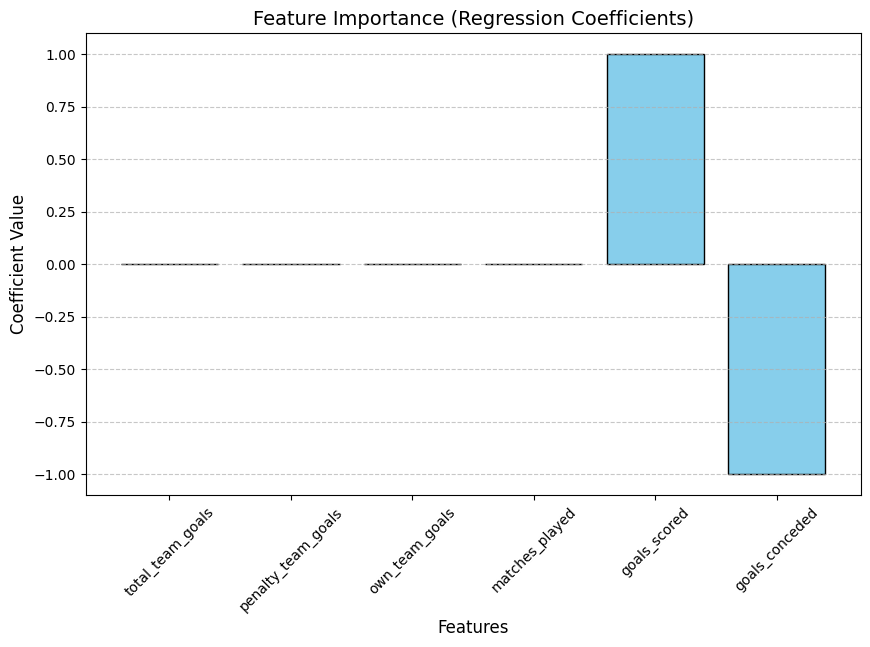

In [39]:

# Enhanced Feature Importance Plot
plt.figure(figsize=(10, 6))
plt.bar(X.columns, player_impact_model.coef_, color="skyblue", edgecolor="black")
plt.title('Feature Importance (Regression Coefficients)', fontsize=14)
plt.ylabel('Coefficient Value', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


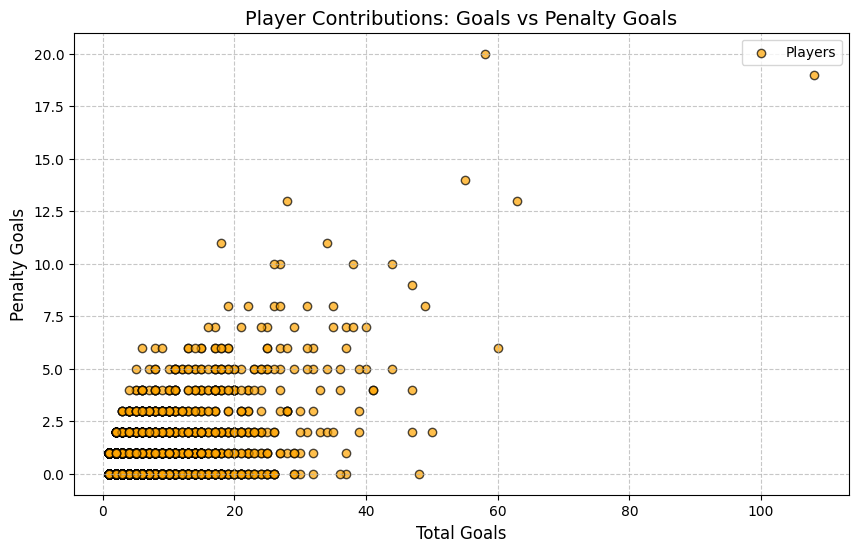

In [40]:

# Scatter Plot for Player Contributions
plt.figure(figsize=(10, 6))
plt.scatter(offensive_stats['total_goals'], offensive_stats['penalty_goals'], alpha=0.7, label="Players", color="orange", edgecolor="black")
plt.title('Player Contributions: Goals vs Penalty Goals', fontsize=14)
plt.xlabel('Total Goals', fontsize=12)
plt.ylabel('Penalty Goals', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
